In [ ]:
# Install Java, Spark, and Findspark
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://www-us.apache.org/dist/spark/spark-2.4.7/spark-2.4.7-bin-hadoop2.7.tgz
!tar xf spark-2.4.7-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.7-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()

Get:1 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:5 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:6 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:7 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:8 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:9 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:11 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic/main Sources [1,746 kB]
Ign:12 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:13 https://developer.download.nvidia.co

In [ ]:
# I have yelp 100k dataset loaded into my google drive
# this allows me to access that data from inside spark
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
# Start a SparkSession
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("word2vec").getOrCreate()

In [ ]:
from pyspark.sql.types import StructType, StructField, StringType
from pyspark.ml.feature import Word2Vec
import string

schema = StructType([StructField("text", StringType(), True)])

In [ ]:
# This URL is on my gdrive only! I loaded it there from a download from the internet
url = "/content/gdrive/MyDrive/covidvaccinedata_2021-03-13_v2_AGP_-JAN01-10-2021.csv"
df = spark.read.schema(schema).csv(url, sep=",", header=False)

In [ ]:
df.show(truncate=False)

+-----------------------------------------------------------------------------------------------------------------+
|text                                                                                                             |
+-----------------------------------------------------------------------------------------------------------------+
|TEXT_CLEANED                                                                                                     |
|Steven Brenburg  pharmacist who intentionally compromised  vaccines in Wisconsin has been arrested               |
|Fantastic article by  describing reasons for vaccine hesitancy                                                   |
|CovidVaccine                                                                                                     |
|  "                                                                                                              |
|Portl TribuneOregon Portl katebrown pdx protests CovidVaccine          

In [ ]:
# punctuation removal due to relatively small datasize
def remove_punctuation(txt):
  return "".join(l if l not in string.punctuation else "" for l in txt)

In [ ]:
from pyspark.sql.functions import col, udf

remove_punctuation_udf = udf(remove_punctuation, StringType())
remove_punctuation_udf

<function __main__.remove_punctuation>

In [ ]:
df = df.withColumn("clean_text", remove_punctuation_udf(col("text")))
df.show()

+--------------------+--------------------+
|                text|          clean_text|
+--------------------+--------------------+
|        TEXT_CLEANED|         TEXTCLEANED|
|Steven Brenburg  ...|Steven Brenburg  ...|
|Fantastic article...|Fantastic article...|
|       CovidVaccine |       CovidVaccine |
|                   "|                    |
|Portl TribuneOreg...|Portl TribuneOreg...|
|I wish crowds wer...|I wish crowds wer...|
|Fuck  vaccine Thi...|Fuck  vaccine Thi...|
|Im gonna need you...|Im gonna need you...|
|How  coronavirus ...|How  coronavirus ...|
|My CovidVaccine i...|My CovidVaccine i...|
|Why is  CovidVacc...|Why is  CovidVacc...|
|Flagging this ide...|Flagging this ide...|
|Crimes Against Hu...|Crimes Against Hu...|
|vaccines vaccineS...|vaccines vaccineS...|
|CovidVaccine WeWi...|CovidVaccine WeWi...|
|In two days Ive h...|In two days Ive h...|
|vaccines CovidVac...|vaccines CovidVac...|
|    Wake Up   Watch |    Wake Up   Watch |
|                   "|          

In [ ]:
# pandas dataframe to measure length
df_new = df.toPandas()
len(df_new)

13033

In [ ]:
from pyspark.sql.functions import length
length(df.text)

Column<b'length(text)'>

In [ ]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from pyspark.ml import Pipeline

# "Creating pipeline..."
tokenizer = Tokenizer(inputCol="clean_text", outputCol="token_text")
stopremove = StopWordsRemover(inputCol='token_text', outputCol='features')

pipeline = Pipeline(stages=[tokenizer, stopremove])

# "Training model..."
pipeline_stg = pipeline.fit(df)
final_df = pipeline_stg.transform(df)
final_df.show()

+--------------------+--------------------+--------------------+--------------------+
|                text|          clean_text|          token_text|            features|
+--------------------+--------------------+--------------------+--------------------+
|        TEXT_CLEANED|         TEXTCLEANED|       [textcleaned]|       [textcleaned]|
|Steven Brenburg  ...|Steven Brenburg  ...|[steven, brenburg...|[steven, brenburg...|
|Fantastic article...|Fantastic article...|[fantastic, artic...|[fantastic, artic...|
|       CovidVaccine |       CovidVaccine |      [covidvaccine]|      [covidvaccine]|
|                   "|                    |                  []|                  []|
|Portl TribuneOreg...|Portl TribuneOreg...|[portl, tribuneor...|[portl, tribuneor...|
|I wish crowds wer...|I wish crowds wer...|[i, wish, crowds,...|[wish, crowds, co...|
|Fuck  vaccine Thi...|Fuck  vaccine Thi...|[fuck, , vaccine,...|[fuck, , vaccine,...|
|Im gonna need you...|Im gonna need you...|[im, gonna,

In [ ]:
# in class I had used vectorsize of 200 and max iterations of 2
word2vec = Word2Vec(
    vectorSize=200,
    seed=42,
    inputCol="features",
    outputCol="model"
).setMaxIter(3)
model = word2vec.fit(final_df)

In [ ]:
model.getVectors().show(truncate=False)

+-------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
vecs = model.getVectors()

In [ ]:
vecs.filter(vecs["word"] == "incident").show()

+----+------+
|word|vector|
+----+------+
+----+------+



In [ ]:
# TEST WORDS HERE
model.findSynonymsArray("shot", 20)

[('dose', 0.934407651424408),
 ('dosage', 0.9016324281692505),
 ('jab', 0.8938957452774048),
 ('round', 0.8912765383720398),
 ('girl', 0.8321085572242737),
 ('dos', 0.8227056860923767),
 ('yesterday', 0.8192747235298157),
 ('weeks', 0.7993649244308472),
 ('pt', 0.7855202555656433),
 ('took', 0.7854751348495483),
 ('pfizer', 0.7834057807922363),
 ('experiencing', 0.7641504406929016),
 ('batch', 0.7585644721984863),
 ('gave', 0.747900128364563),
 ('mycovidvax', 0.7443434596061707),
 ('ago', 0.7417571544647217),
 ('counting', 0.7315436601638794),
 ('definitely', 0.7270073890686035),
 ('yay', 0.7220559120178223),
 ('complete', 0.7208074331283569)]

In [ ]:
w2v = model.transform(final_df)

In [ ]:
w2v.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+
|                text|          clean_text|          token_text|            features|               model|
+--------------------+--------------------+--------------------+--------------------+--------------------+
|        TEXT_CLEANED|         TEXTCLEANED|       [textcleaned]|       [textcleaned]|[0.0,0.0,0.0,0.0,...|
|Steven Brenburg  ...|Steven Brenburg  ...|[steven, brenburg...|[steven, brenburg...|[-0.0314479693770...|
|Fantastic article...|Fantastic article...|[fantastic, artic...|[fantastic, artic...|[0.01845789577678...|
|       CovidVaccine |       CovidVaccine |      [covidvaccine]|      [covidvaccine]|[0.08889778703451...|
|                   "|                    |                  []|                  []|         (200,[],[])|
|Portl TribuneOreg...|Portl TribuneOreg...|[portl, tribuneor...|[portl, tribuneor...|[0.01269968386207...|
|I wish crowds wer...|I wish crowds w

In [ ]:
w2v_clustering = w2v.select(
    "text", "model"
).withColumnRenamed("model", "features")

In [ ]:
w2v_clustering.show(truncate=False)

+-----------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
from pyspark.ml.feature import PCA
from pyspark.mllib.linalg import Vectors

pca = PCA(k=10, inputCol="features", outputCol="pcaFeatures")
PCAmodel = pca.fit(w2v_clustering)
result = PCAmodel.transform(w2v_clustering)
result.show(truncate=False)

+-----------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
result = result.select("text", "pcaFeatures")
w2v_clustering = result.withColumnRenamed("pcaFeatures", "features")
w2v_clustering.show(truncate=False)

+-----------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|text                                                                                                             |features                                                                                                                                                                                                           |
+-----------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|TEXT_CLEANED   

In [43]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

# Trains a k-means model. < TRY NEW GROUP NUMBERS HERE 
kmeans = KMeans().setK(8).setSeed(1)
km_model = kmeans.fit(w2v_clustering)

In [44]:
# Make predictions
predictions = km_model.transform(w2v_clustering)

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator(distanceMeasure="cosine")

# TEST YOUR FIT
# silhouette score goes between -1, 1. 1 is better. Negative is bad
silhouette = evaluator.evaluate(predictions)
print("Silhouette with cosine distance = " + str(silhouette))

Silhouette with cosine distance = 0.2953236778810649


In [ ]:
# AGP INSERT >> FIND BEST CLUSTER Size? ["Elbow Method"]
import numpy as np
import pandas as pd

# Calculate clusterSize and plot
clusterSize = np.zeros(15)

for k in range(2,15):
    # Trains a k-means model.
    kmeans = KMeans().setK(k).setSeed(1)
    km_model = kmeans.fit(w2v_clustering)
    predictions = km_model.transform(w2v_clustering)
    evaluator = ClusteringEvaluator(distanceMeasure="cosine")
    clusterSize[k] = evaluator.evaluate(predictions)

# Define the dataframe of cosines
df_clusterSize = pd.DataFrame(clusterSize[2:])
df_clusterSize.columns = ["cosine"]
new_col = [2,3,4,5,6,7,8,9,10,11,12,13,14]
df_clusterSize.insert(0, 'cluster', new_col)

df_clusterSize

,cluster,cosine
0,2,0.000000
1,3,0.259747
2,4,0.000000
3,5,0.000000
4,6,0.146219
5,7,0.190580
6,8,0.295324
7,9,0.201495
8,10,0.198249
9,11,0.183514


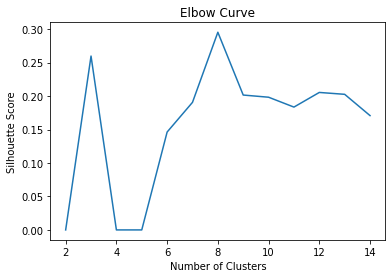

In [ ]:
# PLOT the cosines

import pylab as pl
pl.plot(df_clusterSize.cluster, df_clusterSize.cosine)
pl.xlabel('Number of Clusters')
pl.ylabel('Silhouette Score')
pl.title('Elbow Curve')
pl.show()

In [ ]:
predictions.show()

+--------------------+--------------------+----------+
|                text|            features|prediction|
+--------------------+--------------------+----------+
|                text|[0.0,0.0,0.0,0.0,...|         0|
|Serum Institute O...|[0.08654927176670...|         0|
|10 centres short ...|[-0.0512182234762...|         0|
|Serum Institute O...|[-0.0209223019045...|         0|
|     What about this|[-0.5699329986883...|        11|
|AstraZeneca vacci...|[-0.2260921952385...|        12|
|                   "|[-0.5699329986883...|        11|
|Oxford University...|[0.13859190578427...|         0|
|COVID19 Vaccine U...|[-0.1591613315153...|        12|
|Hopes for our fut...|[0.0,0.0,0.0,0.0,...|         0|
|CovidVaccine Bill...|[-0.4248171621771...|        12|
|Bill Gates Spendi...|[-0.0915733827183...|         0|
|CovidVaccine  Rus...|[-0.1365770536064...|        13|
| AstraZeneca Covi...|[-0.2134449347830...|         3|
| Thats one good r...|[-0.2434939249709...|         3|
|Serum Ins

In [ ]:
predictions.filter("prediction=6").show(50, truncate=False)

+---------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|text                                               |features                                                                                                                                                                                                           |prediction|
+---------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|AstraZeneca CovidVaccine QuickTake                 |[-0.5042872232435108,-0.4244550587161168,-0.09282570179091675,0.09685284144724195,0.04865785002721759,7.357510826703